# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
plt.style.use('ggplot')

COLOR_FEMALE = cm.get_cmap("RdBu")(220) # set blue for female
COLOR_MALE = cm.get_cmap("RdBu")(35) # set red for male
TITLE_SIZE = 22
TITLE_PADDING = 10

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import os
import sys
import glob
from shutil import copyfile
import time
from tabulate import tabulate
from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score

from sklearn import set_config
set_config(display='diagram')

import umap 

# efficiently save and load scikit models
from joblib import dump, load

In [21]:
import librosa
import librosa.display

import pydub
from pydub import AudioSegment, effects

import soundfile

from aubio import source, pitch

# Helper functions

In [5]:
def umap_reduce_and_plot(features, labels, n_neighbors=25, 
                         title=None, alpha=1, gender=True, cmap="tab20"):
    
    umapper = umap.UMAP(n_neighbors=25, random_state=1)
    feat_umap = umapper.fit_transform(features)

    plt.figure(figsize=(12,8))
    if gender == True:
        plt.scatter(feat_umap[labels, 0], feat_umap[labels, 1], 
                    color=COLOR_MALE, alpha=alpha)
        plt.scatter(feat_umap[np.invert(labels), 0], feat_umap[np.invert(labels), 1], 
                    color=COLOR_FEMALE, alpha=alpha)

        # https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
        lgd = plt.legend(["male", "female"])
        for lh in lgd.legendHandles: 
            lh.set_alpha(1)
    else:
        plt.scatter(feat_umap[:, 0], feat_umap[:, 1], 
            c=labels, cmap=cmap, alpha=alpha)
        
    plt.title(title, size=24, pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return feat_umap

In [6]:
SAMPLE_RATE        = 48_000
MFCC_MIN_FREQUENCY = 60
MFCC_MAX_FREQUENCY = 8_000
MFCC_BANDS         = 80
FO_CUTOFF_UPPER    = 1_500
HOP_LENGTH         = 512


def get_fO(audio, sample_rate):
    # create empty array to return in case processing fails
    empty_ = np.empty(5,)
    empty_[:] = np.nan

    splits_cnt = int(len(audio)/HOP_LENGTH)
    splits = [audio[x*HOP_LENGTH : x*HOP_LENGTH + HOP_LENGTH] for x in range(0, splits_cnt)]
    
    pitch_o = pitch("yinfast", samplerate=sample_rate)
    pitches = []
    for split in splits:
        pitch_ = pitch_o(split)[0]
        confidence = pitch_o.get_confidence()
        if confidence < 0.8: 
            pitch_ = 0.
        pitches.append(pitch_) 

    if len(pitches)==0:
        return empty_

    fO = [0.0 if x>FO_CUTOFF_UPPER else x for x in pitches]
    fO = [x for x in fO if x!=0.0]

    if len(fO)==0:
        return empty_ 

    return (np.mean(fO), np.median(fO), np.std(fO), np.min(fO), np.max(fO))


def pydub_to_np(audio):
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)).T


def detect_leading_silence(audio, silence_threshold=-50.0, chunk_size=10):
    trim_ms = 0 # ms
    assert chunk_size > 0 # to avoid infinite loop
    while audio[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(audio):
        trim_ms += chunk_size
    return trim_ms


def get_features(file, secs_to_process=2):
    # create empty array to return in case processing fails
    empty_ = np.empty(85,)
    empty_[:] = np.nan 
    
    audio_file = AudioSegment.from_file(file)
    sample_rate = audio_file.frame_rate

    # normalize audio levels
    try:
        audio_file = effects.normalize(audio_file)  
    except Exception as e:
        print(f"{file} can't be normalized")
        return empty_  
        
    waveform = pydub_to_np(audio_file)

    if waveform.ndim == 2: # check if file is stereo 
        waveform = waveform.mean(axis=0) # if stereo merge channels by averaging

    if len(waveform)>0:
        fO_ = get_fO(waveform, sample_rate)
        mfcc_ = np.mean(librosa.feature.mfcc(y=waveform, 
                                             sr=sample_rate, 
                                             n_mfcc=MFCC_BANDS, 
                                             fmin=MFCC_MIN_FREQUENCY,
                                             fmax=MFCC_MAX_FREQUENCY,
                                            ), axis=1) 
        return np.hstack([fO_, mfcc_])
    
    else:
        return empty_    

    
def get_cols():
    mel_to_Hz = librosa.mel_frequencies(n_mels=MFCC_BANDS, 
                                        fmin=MFCC_MIN_FREQUENCY, 
                                        fmax=MFCC_MAX_FREQUENCY)
    
    cols = ["fO_mean", "fO_median", "fO_std", "fO_min", "fO_max"]
    cols_mel = [f"{x:.0f}" + "_Hz" for x in mel_to_Hz]
    cols.extend(cols_mel)
    return cols
    
    
def process_audio_files(file_paths, secs_to_process=2):
    features = []
    for file_path in tqdm(file_paths):
        features.append(get_features(file_path, secs_to_process=secs_to_process))
    features = pd.DataFrame(features)
    features.columns = get_cols()
    return features

# 1) Loading the data, training the classifier

Load prepared data and train a Logistic regression with best hyperparameters.

In [8]:
# load multiple languages
seconds_processed = 2

metas = []
feats = []

languages = ["_german", "_french", "_italian", "_romansh"]
for language in languages:
    metas.append(pd.read_parquet(f"_saved_features/cv{language}_meta.parq"))
    feats.append(pd.read_parquet(f"_saved_features/cv{language}_features.parq"))

meta = pd.concat(metas).reset_index(drop=True)
feat = pd.concat(feats).reset_index(drop=True)

In [9]:
%%time
pipe = make_pipeline(QuantileTransformer(), LogisticRegression(max_iter=1e6, C=0.4))
pipe.fit(feat, meta.gender)

CPU times: user 5.31 s, sys: 909 ms, total: 6.21 s
Wall time: 2.32 s


Pipeline(steps=[('quantiletransformer', QuantileTransformer()),
                ('logisticregression',
                 LogisticRegression(C=0.4, max_iter=1000000.0))])

# 2) Analyzing a prototypical podcast episode
- As an example for the full analysis workflow I choose one episode of a German podcast about personal finance advice.
- **This is an easier example for gender analysis.** There are just two hosts, one female, one male. There is not a lot of music or sound effects being used and the hosts almost never interrupt each other but rather speak uninterrupted for longer time frames.

In [10]:
secs_to_process = 2
episode_name = "finance_podcast"

In [11]:
start = int(time.time())

# empty all folders for intermediate files
!rm _data/_podcasts/_chunks/*
!rm _data/_podcasts/_low_proba/*
!rm _data/_podcasts/_predicted_female/*
!rm _data/_podcasts/_predicted_male/*

In [12]:
# use ffmpeg to cut podcast episode in chunks of length n (2 seconds chunks as sensible default)
_ = !ffmpeg -i _data/_podcasts/podcasts_raw/"{episode_name}".mp3 -map 0 -f segment -segment_time $secs_to_process -c copy -vn _data/_podcasts/_chunks/"{episode_name}"_%04d.mp3

In [13]:
# get filenames of chunks and extract features for all segments
frames = []
podcast_seqments = glob.glob("_data/_podcasts/_chunks/*")
podcast_seqments = sorted(podcast_seqments)
pod_meta = pd.DataFrame(podcast_seqments, columns=["file_path"])
pod_feat = process_audio_files(pod_meta.file_path, secs_to_process=secs_to_process)

  0%|          | 0/581 [00:00<?, ?it/s]

In [14]:
print(f"The given episode «{episode_name}» is {len(pod_feat)*secs_to_process/60:.0f} minutes long.")
pod_feat.dropna(inplace=True)
print(f"Segments for which features couldn't be extracted: {len(pod_meta) - len(pod_feat)}")
pod_meta = pod_meta.reindex(pod_feat.index)

pod_meta.reset_index(drop=True, inplace=True)
pod_feat.reset_index(drop=True, inplace=True)

The given episode «finance_podcast» is 19 minutes long.
Segments for which features couldn't be extracted: 0


In [15]:
pod_preds = pipe.predict(pod_feat)
pod_preds_labels = np.where(pod_preds=="male", True, False)
pod_proba = pipe.predict_proba(pod_feat)
pod_meta["predicted"] = pod_preds
pod_meta["predicted_proba"] = pod_proba.max(axis=1)

- **The classifier seems much more confident about the male samples.** 
- Possible explanation: **The production quality of the podcast is very good and gives both speakers deep and sonorous voices.** The classifier was trained on the much worse recording quality of the CommonVoice samples. The male voice therefore is easy to classify, having more additional vocal depth from production. The female voice also tends towards a lower male frequency spectrum due to the audio production quality and therefore is considered as more male in the classification logic of the trained model (but still classified correctly). 

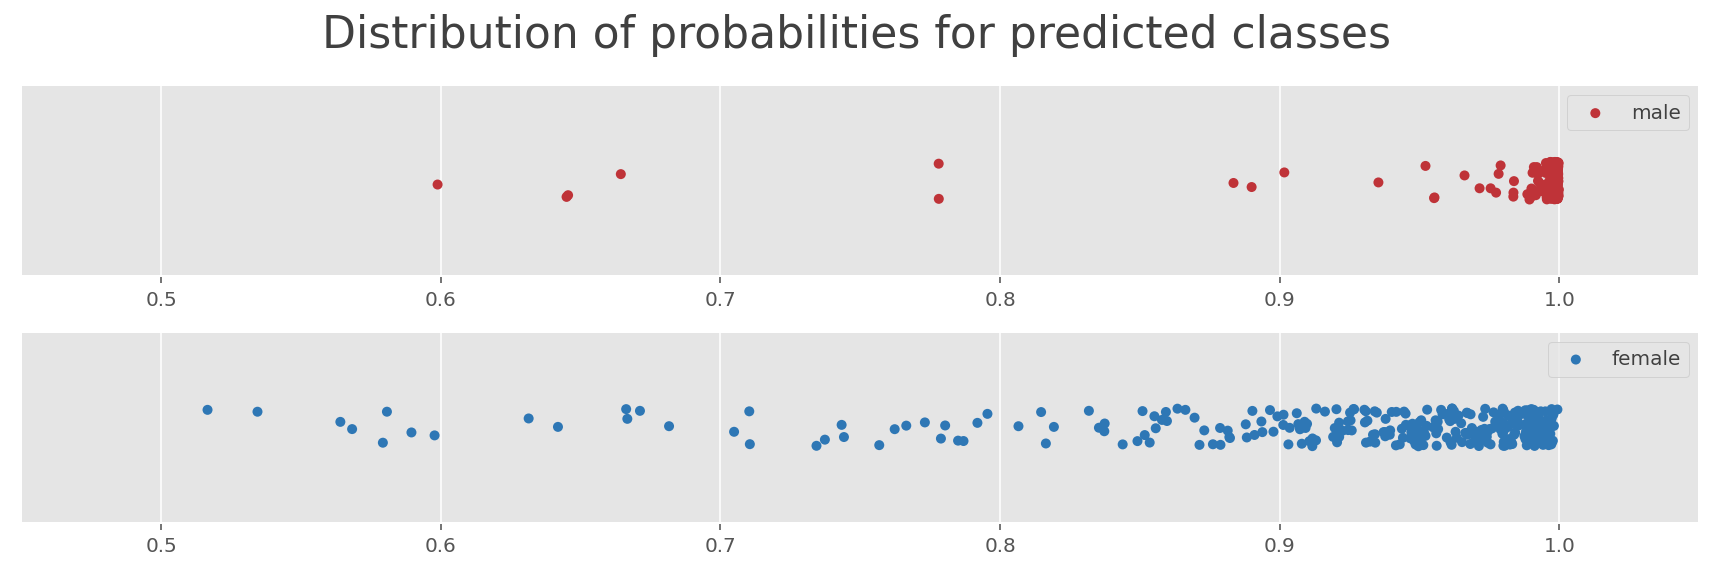

In [16]:
_, (ax1, ax2) = plt.subplots(2,1, figsize=(12,4))
plt.suptitle("Distribution of probabilities for predicted classes", size=TITLE_SIZE)
sns.stripplot(data=pod_meta[pod_meta.predicted=="male"], color=COLOR_MALE, orient="horizontal", ax=ax1)
sns.stripplot(data=pod_meta[pod_meta.predicted=="female"], color=COLOR_FEMALE, orient="horizontal", ax=ax2)
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xlim(0.45, 1.05)
ax2.set_xlim(0.45, 1.05)
ax1.legend(["male"])
ax2.legend(["female"])
plt.tight_layout()
plt.show()

- Reducing the feature dimensions to 2D with UMAP and plotting these with the predicted labels reveals distinct and well separated clusters. 
- There are just a few red and likely erroneous samples visible in the blue clusters.

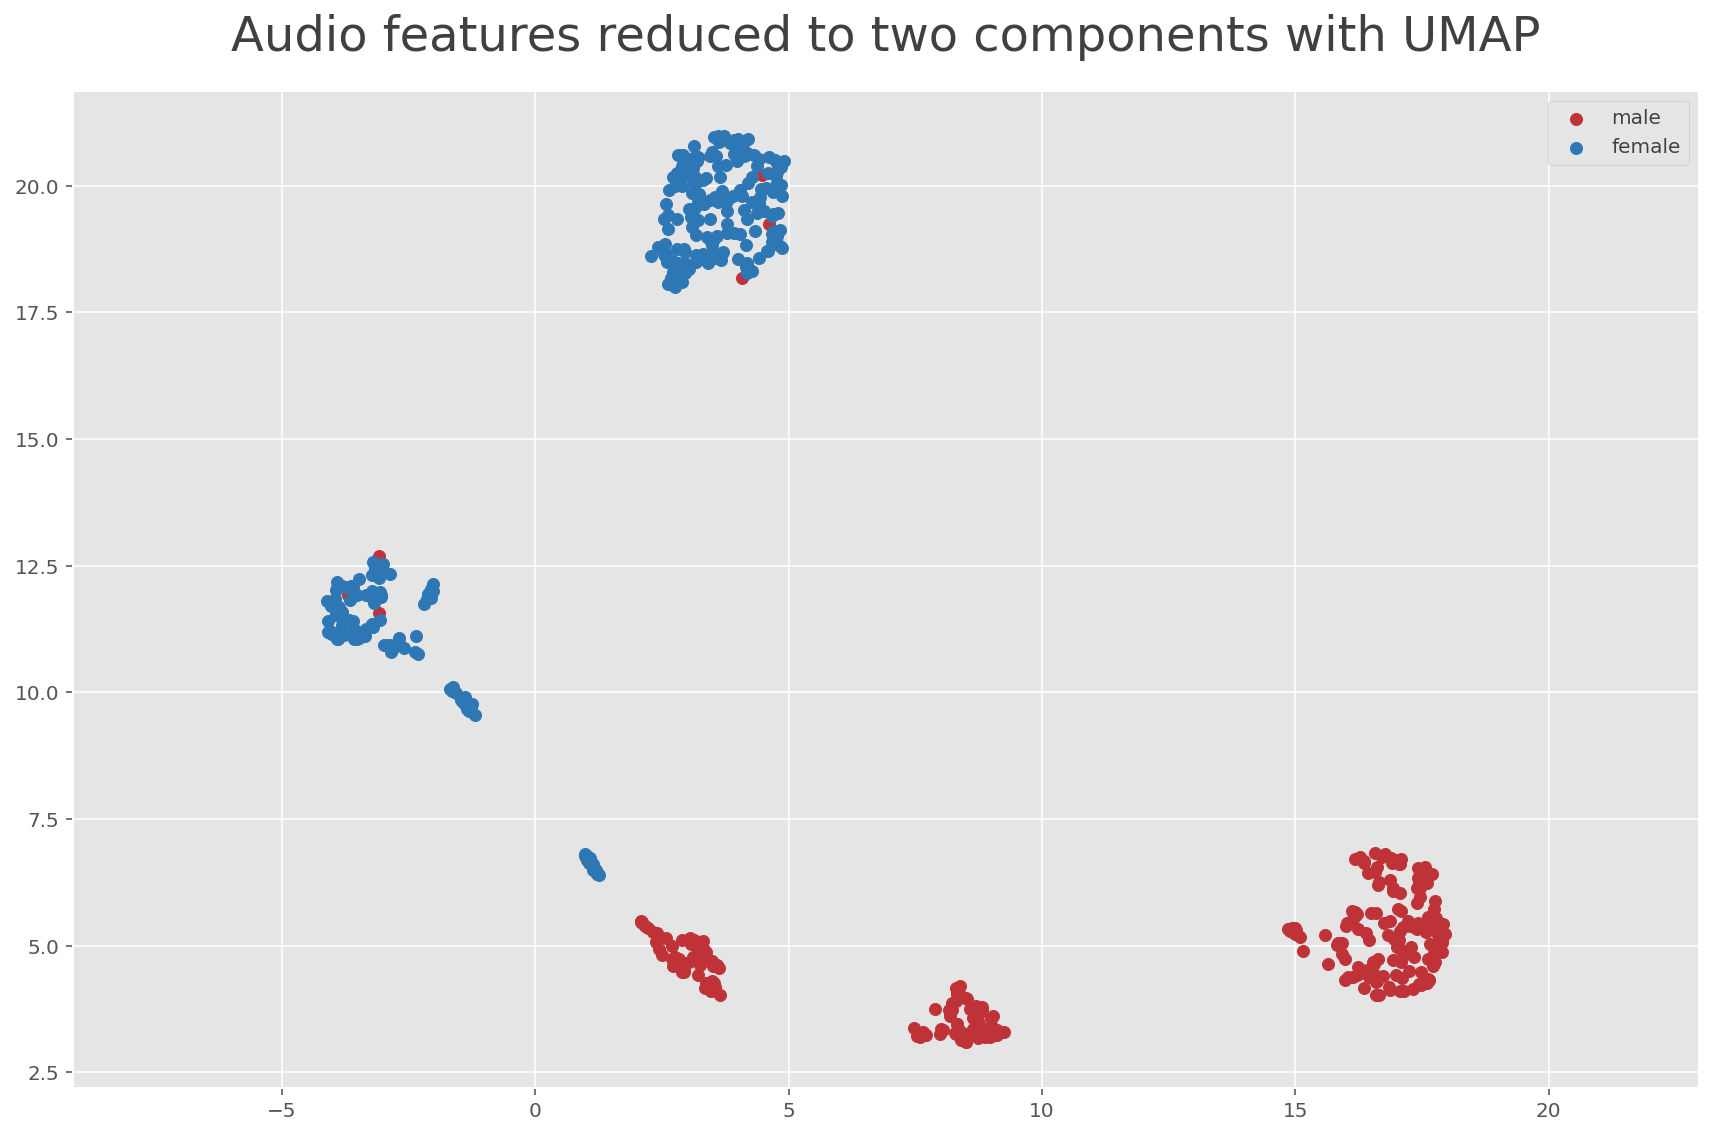

In [17]:
umap_feats = umap_reduce_and_plot(pod_feat, pod_preds_labels, n_neighbors=100, gender=True,
                                 title="Audio features reduced to two components with UMAP")

By examining the predicted samples **I can confirm that almost all predictions are correct.**

In [18]:
# copy audio samples to separate directories where the classifier is very unsure about prediction
low_threshold = 0.6
low_proba = pod_meta[pod_meta.predicted_proba <= low_threshold].dropna().index
low_proba_count = len(low_proba)

pod_low_proba = pod_meta.iloc[low_proba]
for filename in pod_low_proba.file_path.values:
    file = filename.split("_chunks/")[1]
    destination = f"_data/_podcasts/_low_proba/{file}"
    copyfile(filename, destination)

In [19]:
# copy audio samples to separate directory for each class
for prediction in ["male", "female"]:
    for filename in pod_meta[pod_meta.predicted==prediction].file_path.values:
        file = filename.split("_chunks/")[1]
        destination = f"_data/_podcasts/_predicted_{prediction}/{file}"
        copyfile(filename, destination)

**The calculated gender ratio seems plausible based on manually checking the predictions.**

In [20]:
# print report
label_ratio = pod_meta.predicted.value_counts(normalize=True)
print(f"Gender ratio of {episode_name}:")
print(tabulate(label_ratio.to_frame(), floatfmt=".2f"))
print()

print(f"There are {low_proba_count} ({100/len(pod_meta)*low_proba_count:.2f}%) predictions with a probability below {low_threshold}.")
print()

end = time.time()
print("Processing time:")
print(f"{end-start:.0f} seconds for the total episode of {len(podcast_seqments)*secs_to_process/60:.0f} minutes")
print(f"{(end-start) / (len(podcast_seqments)*secs_to_process/60):.0f} seconds per minute")
print(f"{(end-start) / (len(podcast_seqments)*secs_to_process/3600):.0f} seconds per hour")
print()

Gender ratio of finance_podcast:
------  ----
female  0.53
male    0.47
------  ----

There are 9 (1.55%) predictions with a probability below 0.6.

Processing time:
37 seconds for the total episode of 19 minutes
2 seconds per minute
114 seconds per hour



# 3) Final thoughts

- **Gender prediction based on the CommonVoice data works in the target domain of podcast media as well.** 
- **Analysis works fast** – it takes only around 1.5 minutes to analyze a full hour of podcast content (including the UMAP calculations). This would allow for high volume analysis of hundreds of episodes in reasonable time.
- **From analyzing more than 50 episodes of various podcasts I can confirm that the prediction accuracy in general is good and seems well within the calculated accuracy.** 
- Logistic regression as the chosen classifier for this prototypical example has **difficulties with voice over music or sound effects.**
- **The trained model makes errors on samples with unusually high pitched male or low pitched female voices** as well.
- At the moment I use a length of 2 seconds for the segments. This seems sufficient granular and at the same time long enough to have enough utterances so that the features can properly be computed. Prediction accuracy would gain from longer segments. Shorter segments would allow for more precise analysis of short forths and backs between speakers.
- **I assume that I need to train on more samples of the target domain to substiantally improve the model's quality.** My impression is that the CommonVoice recordings are a good fundament. At the same time **the CommonVoice samples aren't sufficiently representative in regard to the higher production quality and often professionally trained voices of the target media.**
- Prediction quality would gain too from voice activity detection. This would remove chunks from prediction where no speech is present.

### *One more thing…*
An exemplary analysis of all 191 episodes (78hrs) of the prototypical finance podcast yields the plot below. 
- Each row represents one episode, starting with the row for the first episode at the bottom. 
- Color red indicates a predicted male voice, blue indicates a female voice.
- Around 2% of all predictions had an unusual low probability and likely are wrong.
- **The total share of male voice was 88%.**

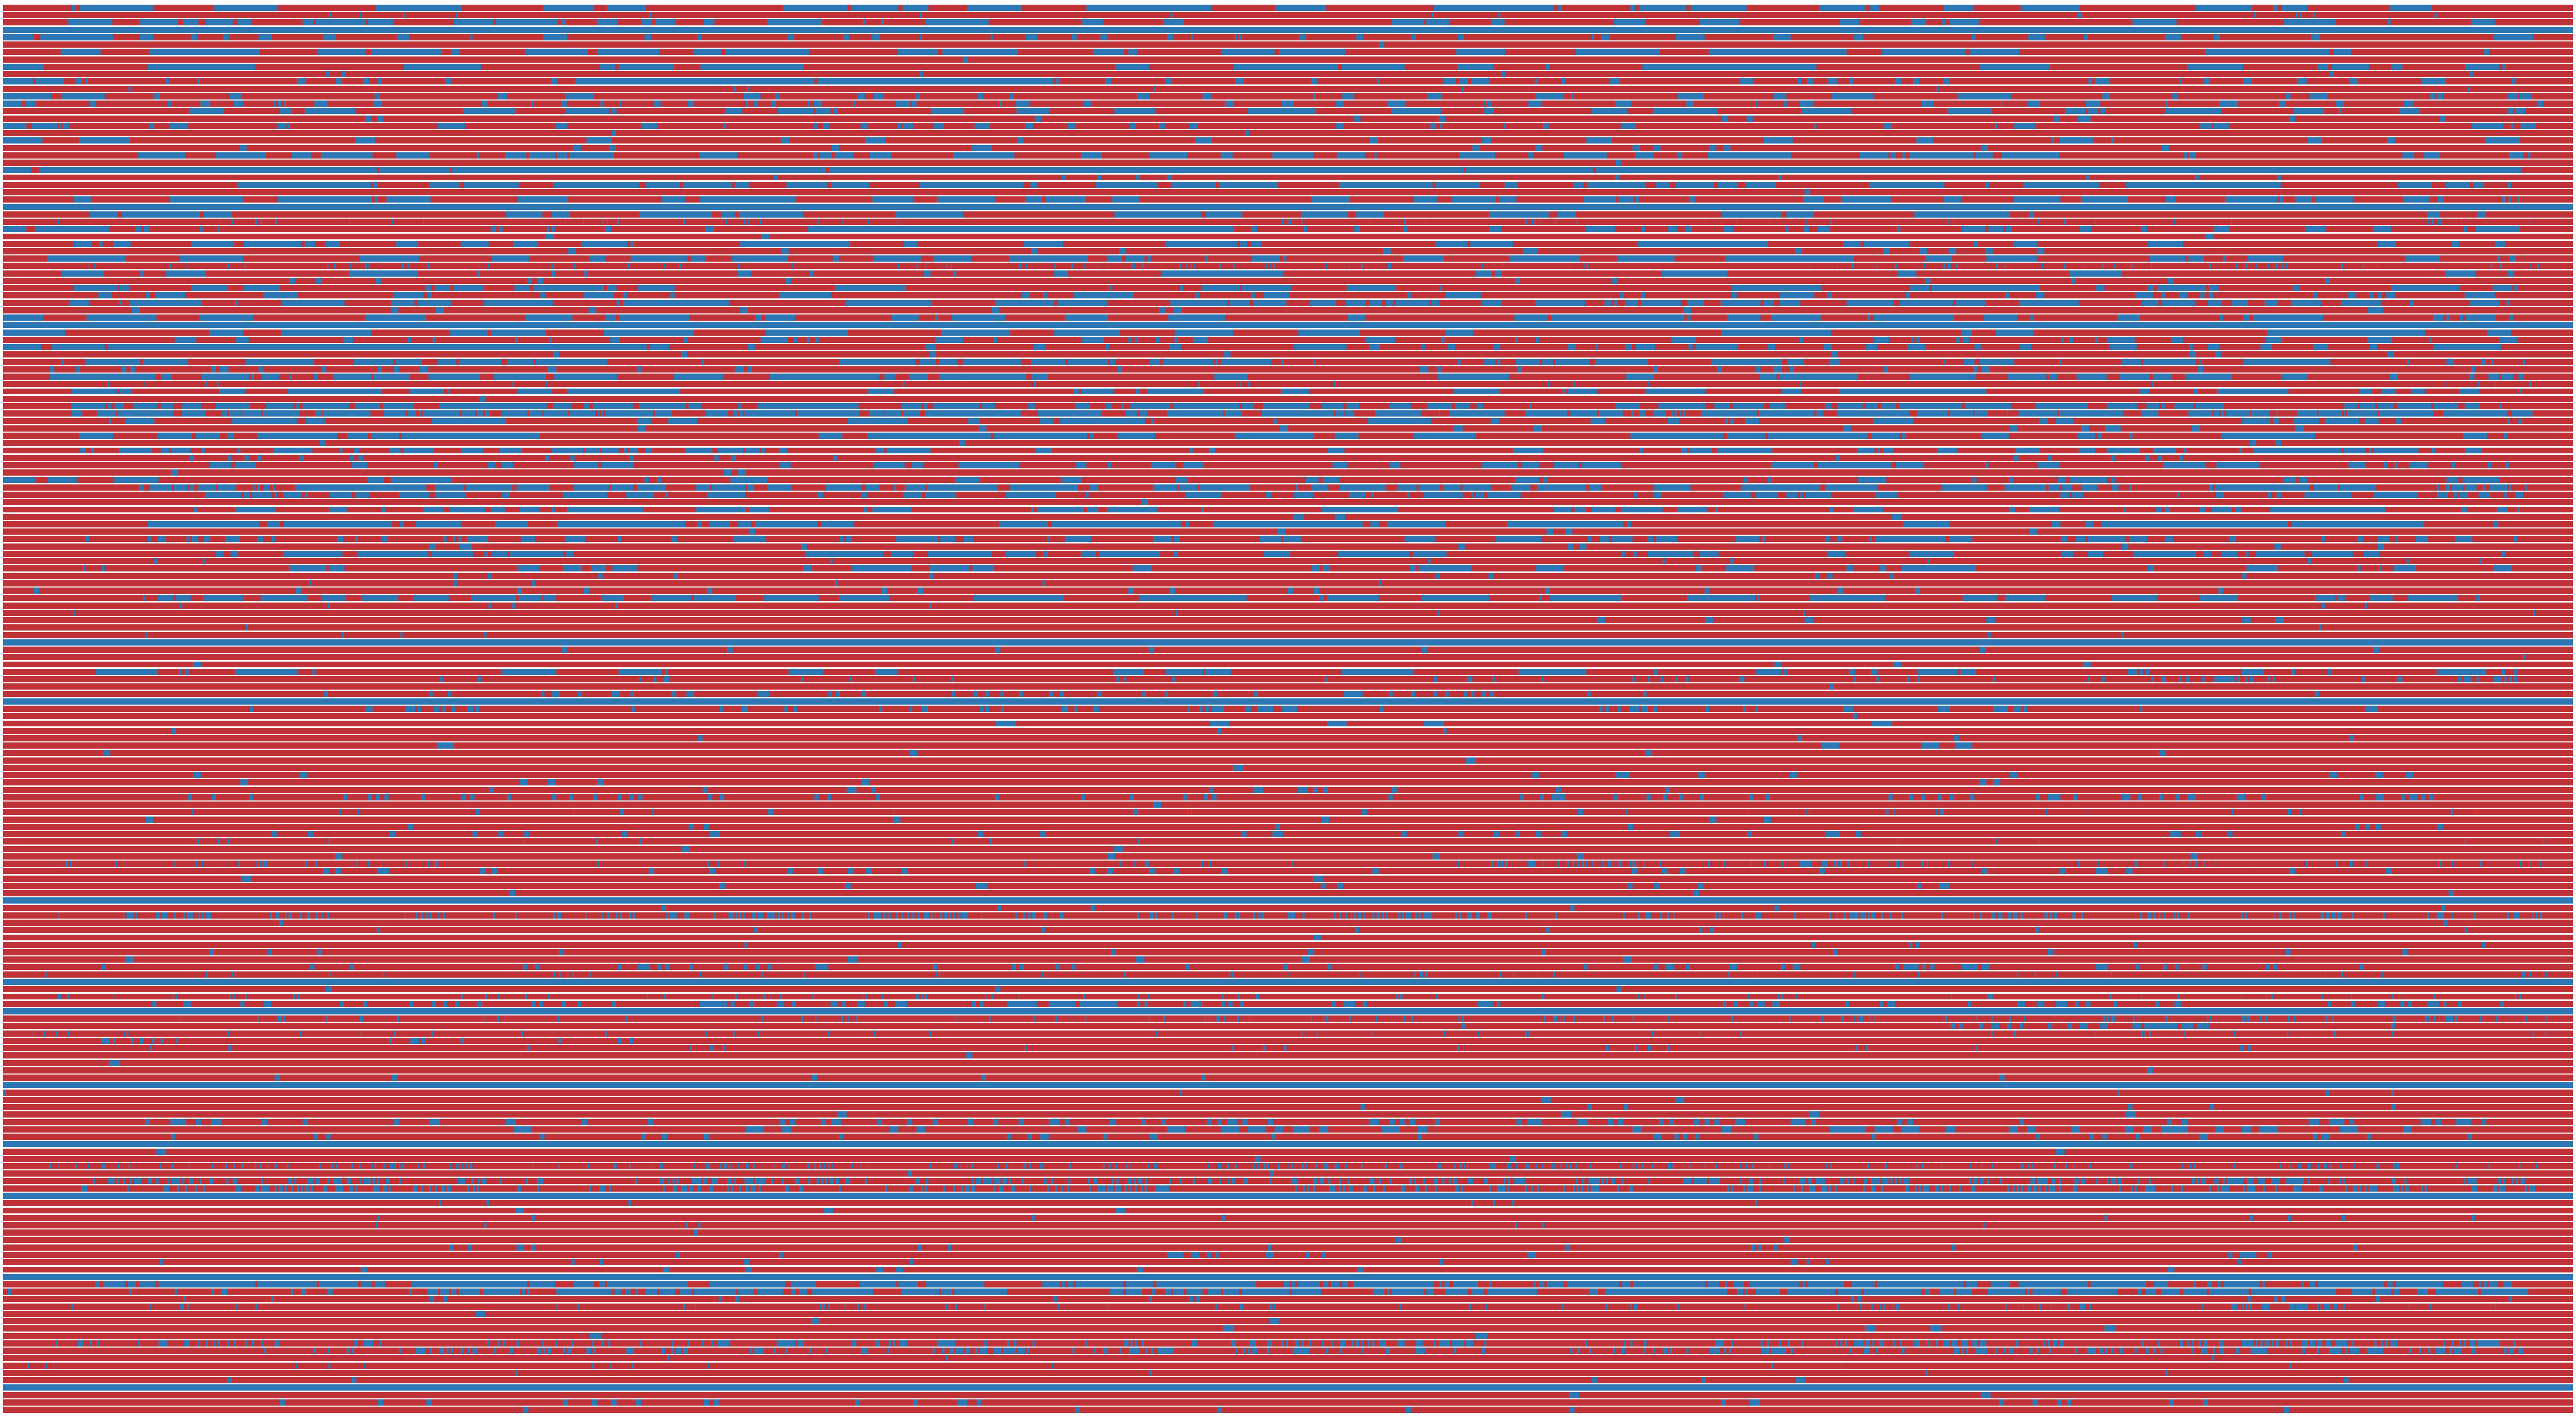